In [1]:
!pip install pyro-ppl

In [24]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle
from IPython.display import clear_output
from copy import deepcopy

import sys
root = '/content/drive/MyDrive/BayesianMatrixNeuralNetworks/CyclonePrediction/'
sys.path.append(root)

for module in ['util', 'models']:
  if module in sys.modules:  
    print(f'Deleting {module}')
    del sys.modules[module]

from models import MatrixNetwork, make_bayes_model
from util import load_data_as_tensor, gradient_descent, variational_bayes, get_posterior_samples

import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro import poutine

Mounted at /content/drive
Deleting util
Deleting models


# Data
- can use argument use_gpu=True

In [3]:
use_gpu = False
if use_gpu:
  model.cuda()
  torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
  torch.set_default_tensor_type('torch.FloatTensor')

epochs = 10000
patience = 500

In [5]:
X_train, X_val, X_test, y_train, y_val, y_test = load_data_as_tensor(root + "data/", use_gpu=use_gpu)

In [4]:
with open(root + "/data/X_split_train.pkl", "rb") as r:
    X_split_train = pickle.load(r)

with open(root + "/data/X_split_val.pkl", "rb") as r:
    X_split_val = pickle.load(r)

with open(root + "/data/X_split_test.pkl", "rb") as r:
    X_split_test = pickle.load(r)

with open(root + "/data/y_split_train.pkl", "rb") as r:
    y_split_train = pickle.load(r)

with open(root + "/data/y_split_val.pkl", "rb") as r:
    y_split_val = pickle.load(r)

with open(root + "/data/y_split_test.pkl", "rb") as r:
    y_split_test = pickle.load(r)

# Gradient Descent with Simple Model

In [6]:
model = MatrixNetwork(hidden_dim=(10, 10), n_hidden_layers=1)
if use_gpu:
  model.cuda()

model, train_losses_gd, val_losses_gd, _ = gradient_descent(epochs, model, X_train, y_train, X_val, y_val, patience=patience, checkpoint_path=root + "models/checkpoint.pt")

Done: 1000 / 10000 epochs
Train loss (MSE): 10.374151229858398
Val loss (MSE): 19.9912052154541
Time taken: 15.819582223892212s 

Done: 2000 / 10000 epochs
Train loss (MSE): 3.5735116004943848
Val loss (MSE): 6.620241641998291
Time taken: 31.634665489196777s 

Done: 3000 / 10000 epochs
Train loss (MSE): 1.602713704109192
Val loss (MSE): 2.7008450031280518
Time taken: 47.22803616523743s 

Done: 4000 / 10000 epochs
Train loss (MSE): 0.7060503363609314
Val loss (MSE): 1.236655354499817
Time taken: 61.94874429702759s 

Done: 5000 / 10000 epochs
Train loss (MSE): 0.31214073300361633
Val loss (MSE): 0.5727299451828003
Time taken: 76.06842708587646s 

Done: 6000 / 10000 epochs
Train loss (MSE): 0.15359076857566833
Val loss (MSE): 0.3115832507610321
Time taken: 89.77506422996521s 

Done: 7000 / 10000 epochs
Train loss (MSE): 0.08636760711669922
Val loss (MSE): 0.20095133781433105
Time taken: 103.57346796989441s 

Done: 8000 / 10000 epochs
Train loss (MSE): 0.056020598858594894
Val loss (MSE): 

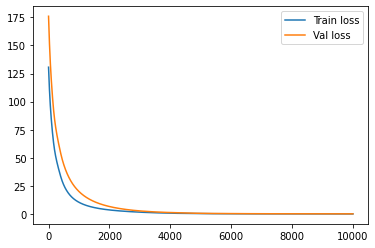

In [7]:
y_pred_train = model(X_train)
y_pred_val = model(X_val)
y_pred_test = model(X_test)

final_train_loss = train_losses_gd[-1]
final_val_loss = val_losses_gd[-1]
with torch.no_grad():
  final_test_loss = nn.MSELoss()(y_pred_test, y_test).item()

plt.plot(train_losses_gd, label="Train loss")
plt.plot(val_losses_gd, label="Val loss")
plt.legend()

# Best model search for matrix NN

In [ ]:
param_dict = {
    'hidden_dim': [(10, 10), (20, 20), (40, 40)],
    'n_hidden_layers': [1, 2]
}

In [ ]:
df_loss = pd.DataFrame({'params': [], 'loss': []})

params = {k: v[0] for k, v in param_dict.items()}
criterion = nn.MSELoss()

for key in param_dict:
  best_loss = np.Inf
  for val in param_dict[key]:
    params[key] = val
    print(params)
    
    model = MatrixNetwork(**params)
    if use_gpu:
      model.cuda()

    model, _, _, _ = gradient_descent(epochs, model, X_train, y_train, X_val, y_val, 
                                      patience=patience, checkpoint_path=root + "models/checkpoint.pt")

    model.eval()
    y_pred_test = model(X_test)
    test_loss = criterion(y_pred_test, y_test)

    df_loss.append({'params': params, 'loss': test_loss}, ignore_index=True)

    if test_loss.item() < best_loss:
      best_loss = test_loss.item()
      best_param = val
      torch.save(model.state_dict(), root + "models/best_MNN.pt")

    clear_output(wait=True)
  params[key] = val

df_loss.pickle(root + "results/loss_MNN")

model = MatrixNetwork(**params)
model.load_state_dict(torch.load(root + "models/best_MNN.pt"))

{'hidden_dim': (50, 50), 'n_hidden_layers': 3}
Done: 1000 / 10000 epochs
Train loss: 0.05188374221324921
Val loss: 0.08982708305120468
Time taken: 96.48106908798218
Done: 2000 / 10000 epochs
Train loss: 0.03610772266983986
Val loss: 0.06288275867700577
Time taken: 191.66325330734253
Done: 3000 / 10000 epochs
Train loss: 0.033332958817481995
Val loss: 0.059004299342632294
Time taken: 285.36181473731995
Stopping early


# Visualise predictions from gradient descent

In [15]:
params = {'hidden_dim': (50, 50), 'n_hidden_layers': 3}
model = MatrixNetwork(**params)
model.load_state_dict(torch.load(root + "models/best_MNN.pt"))

with open(root + "data/X_split_test.pkl", "rb") as r:
  X_split_test = pickle.load(r)

with open(root + "data/y_split_test.pkl", "rb") as r:
  y_split_test = pickle.load(r)

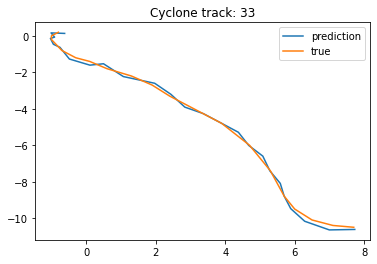

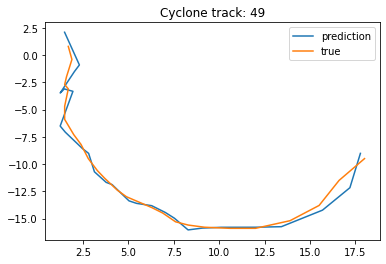

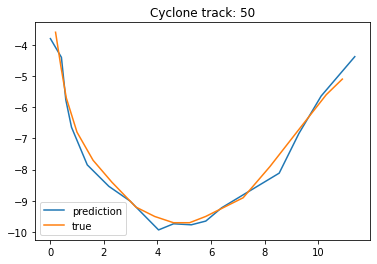

In [16]:
for i in range(3):
  rand_idx = np.random.choice(range(len(y_split_test)))

  X_test_inst = torch.tensor(X_split_test[rand_idx]).type(torch.float)
  y_test_inst = y_split_test[rand_idx]

  model.eval()
  y_pred_test_inst = model(X_test_inst).detach().numpy()

  plt.figure()
  plt.title(f"Cyclone track: {rand_idx}")
  plt.plot(y_pred_test_inst[:, 0], y_pred_test_inst[:, 1], label="prediction")
  plt.plot(y_test_inst[:, 0], y_test_inst[:, 1], label="true")
  plt.legend()

# Variational Bayes

## Train

In [ ]:
epochs = 40000
patience = 2000

In [ ]:
model = MatrixNetwork(hidden_dim=(10, 10), n_hidden_layers=1)

if use_gpu:
  model.cuda()

bayes_model = make_bayes_model(deepcopy(model))
guide = AutoDiagonalNormal(bayes_model)

In [ ]:
pyro.clear_param_store()
train_losses, val_losses = variational_bayes(epochs, bayes_model, guide, X_train, y_train, X_val, y_val, patience=patience, checkpoint_path=root + "models/bayes_checkpoint.pt")

## Inference

In [8]:
num_samples = 1000

model = MatrixNetwork(hidden_dim=(10, 10), n_hidden_layers=1)

if use_gpu:
  model.cuda()

bayes_model = make_bayes_model(deepcopy(model))
guide = AutoDiagonalNormal(bayes_model)

pyro.clear_param_store()
pyro.get_param_store().load(root + "models/bayes_checkpoint.pt")

In [17]:
guide.requires_grad_(False)
return_sites = poutine.trace(bayes_model).get_trace(X_train, y_train).stochastic_nodes + ['_RETURN']
predictive = Predictive(bayes_model, guide=guide, num_samples=num_samples, return_sites=return_sites)

posterior_train, posterior_train_losses = get_posterior_samples(predictive, X_train, y_train)
posterior_val, posterior_val_losses = get_posterior_samples(predictive, X_val, y_val)
posterior_test, posterior_test_losses = get_posterior_samples(predictive, X_test, y_test)

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


### Train, val and test losses

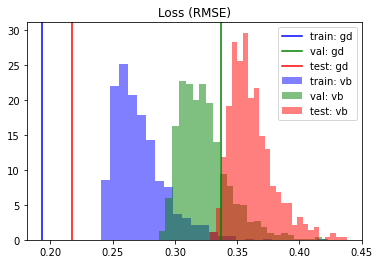

In [18]:
plt.title("Loss (RMSE)")
plt.hist(np.sqrt(posterior_train_losses), label="train: vb", density=True, bins=25, alpha=0.5, color="blue")
plt.axvline(np.sqrt(final_train_loss), label="train: gd", color="blue")
plt.hist(np.sqrt(posterior_val_losses), label="val: vb", density=True, bins=25, alpha=0.5, color="green")
plt.axvline(np.sqrt(final_val_loss), label="val: gd", color="green")
plt.hist(np.sqrt(posterior_test_losses), label="test: vb", density=True, bins=25, alpha=0.5, color="red")
plt.axvline(np.sqrt(final_test_loss), label="test: gd", color="red")
plt.legend()

### Train predictions

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


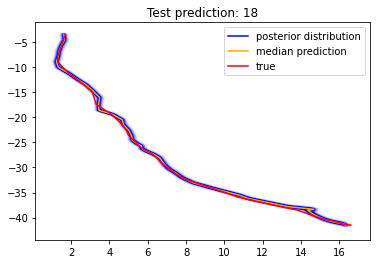

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


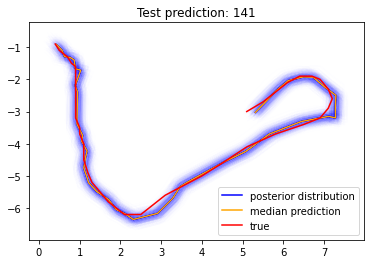

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


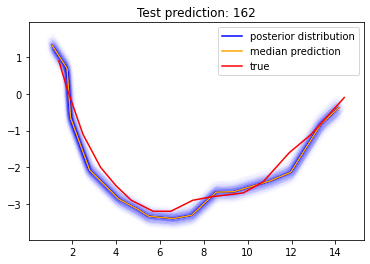

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


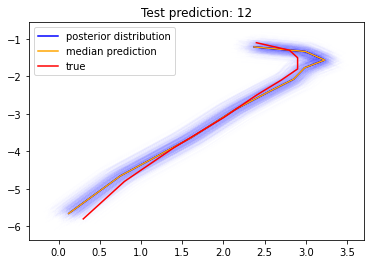

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


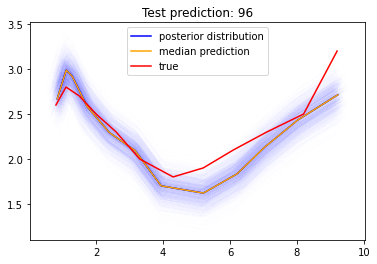

In [29]:
for i in range(5):
  idx = np.random.choice(range(len(y_split_train)))
  X_tmp = torch.tensor(X_split_train[idx]).type(torch.float)
  y_tmp = torch.tensor(y_split_train[idx]).type(torch.float)

  posterior_tmp, _ = get_posterior_samples(predictive, X_tmp, y_tmp)
  y_pred_median = np.median(posterior_tmp['_RETURN'].detach().numpy(), axis=0)

  plt.figure()
  plt.title(f"Test prediction: {idx}")

  plt.plot(y_pred_median[:, 0], y_pred_median[:, 1], color="blue", label='posterior distribution')
  for j in range(num_samples):
    plt.plot(posterior_tmp['_RETURN'][j, :, 0], posterior_tmp['_RETURN'][j, :, 1], alpha=0.005, color="blue")

  plt.plot(y_pred_median[:, 0], y_pred_median[:, 1], color="orange", label='median prediction')
  plt.plot(y_tmp[:, 0].detach().numpy(), y_tmp[:, 1].detach().numpy(), color="red", label='true')
  plt.legend()
  plt.show()

### Val prediction

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


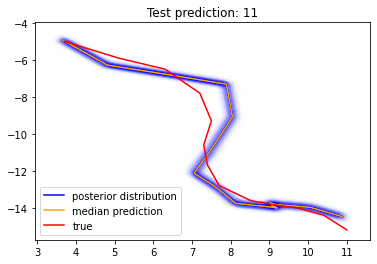

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


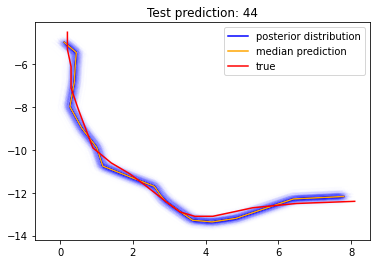

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


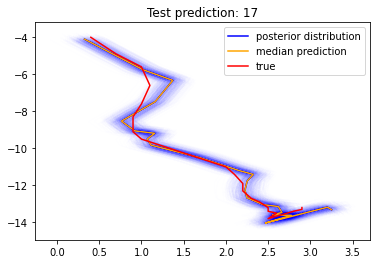

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


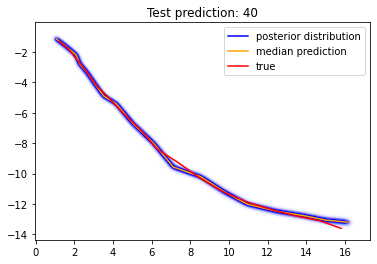

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


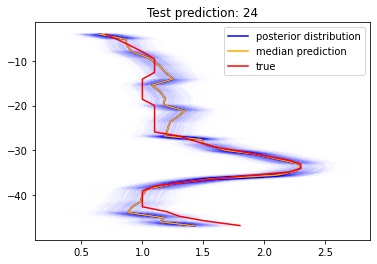

In [28]:
for i in range(5):
  idx = np.random.choice(range(len(y_split_val)))
  X_tmp = torch.tensor(X_split_val[idx]).type(torch.float)
  y_tmp = torch.tensor(y_split_val[idx]).type(torch.float)
  posterior_tmp, _ = get_posterior_samples(predictive, X_tmp, y_tmp)
  y_pred_median = np.median(posterior_tmp['_RETURN'].detach().numpy(), axis=0)

  plt.figure()
  plt.title(f"Test prediction: {idx}")

  plt.plot(y_pred_median[:, 0], y_pred_median[:, 1], color="blue", label='posterior distribution')
  for j in range(num_samples):
    plt.plot(posterior_tmp['_RETURN'][j, :, 0], posterior_tmp['_RETURN'][j, :, 1], alpha=0.005, color="blue")

  plt.plot(y_pred_median[:, 0], y_pred_median[:, 1], color="orange", label='median prediction')
  plt.plot(y_tmp[:, 0].detach().numpy(), y_tmp[:, 1].detach().numpy(), color="red", label='true')
  plt.legend()
  plt.show()

### Test prediction

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


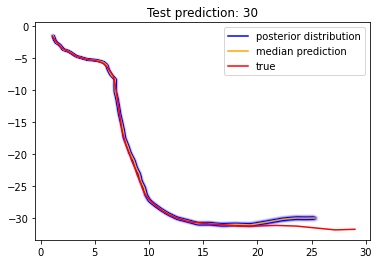

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


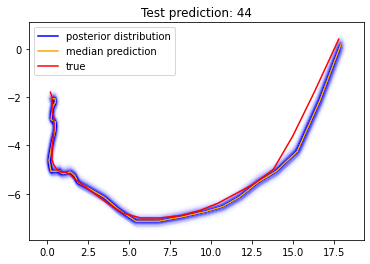

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


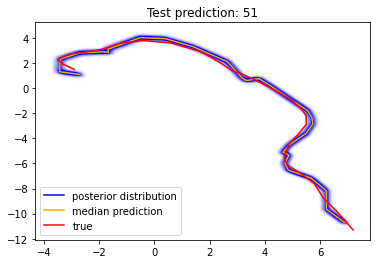

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


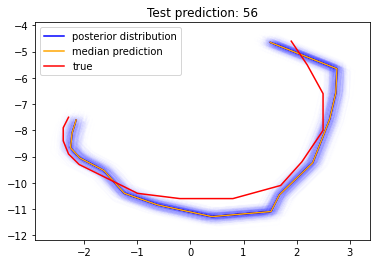

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


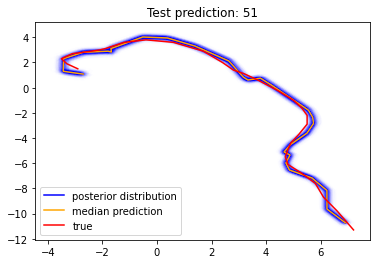

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


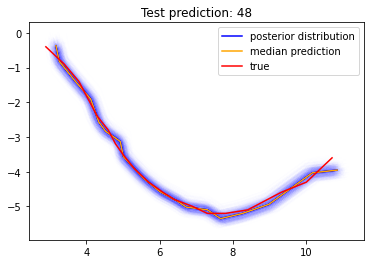

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


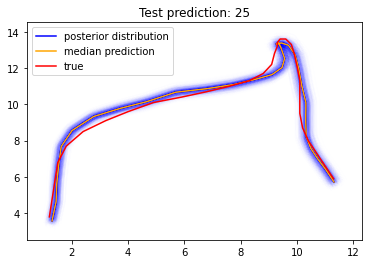

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


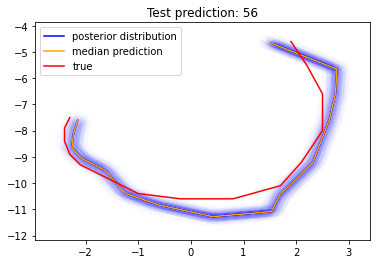

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


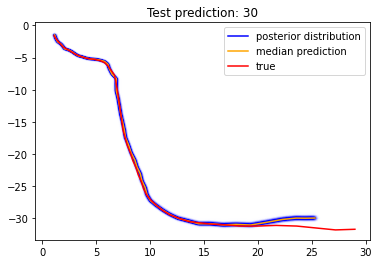

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


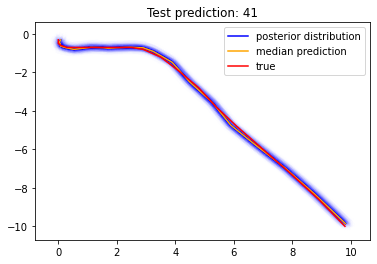

In [30]:
for i in range(10):
  idx = np.random.choice(range(len(y_split_test)))
  X_tmp = torch.tensor(X_split_test[idx]).type(torch.float)
  y_tmp = torch.tensor(y_split_test[idx]).type(torch.float)
  posterior_tmp, _ = get_posterior_samples(predictive, X_tmp, y_tmp)
  y_pred_median = np.median(posterior_tmp['_RETURN'].detach().numpy(), axis=0)

  plt.figure()
  plt.title(f"Test prediction: {idx}")

  plt.plot(y_pred_median[:, 0], y_pred_median[:, 1], color="blue", label='posterior distribution')
  for j in range(num_samples):
    plt.plot(posterior_tmp['_RETURN'][j, :, 0], posterior_tmp['_RETURN'][j, :, 1], alpha=0.005, color="blue")

  plt.plot(y_pred_median[:, 0], y_pred_median[:, 1], color="orange", label='median prediction')
  plt.plot(y_tmp[:, 0].detach().numpy(), y_tmp[:, 1].detach().numpy(), color="red", label='true')
  plt.legend()
  plt.show()